# 🤖 Twemoji Classifier – CS3244 AY24/25 Sem 2

**Group Members:**  
- Jason Matthew Suhari  
- Bryan Castorius Halim  
- Nigel Eng Wee Kiat  
- Muhammad Salman Al Farisi  
- Ng Jia Hao Sherwin  
- Ryan Justyn

This notebook builds and evaluates baseline models for classifying tweets into emojis using the Twemoji dataset. It's the main entry point!

### 1. Imports and Setup 📩

#### 1.1 Utility Imports

In [72]:
import os
import time
from pathlib import Path
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
from dotenv import load_dotenv
import boto3

#### 1.2 ML Imports

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    top_k_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

#### 1.3 Caching Imports

In [ ]:
import pickle
import joblib
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model as keras_load_model

#### 1.4 (Optional) Loading .env file + AWS setup

In [74]:
load_dotenv()
AWS_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION = os.getenv("AWS_REGION")

session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY,
    region_name=AWS_REGION
)

s3 = session.client("s3")

### 2. S3 Bucket Data Loading 🪣

In [63]:
# all of the s3 item urls are kept in urls.txt, maybe we should wrap this into a function in case it isnt
with open("urls.txt", "r") as f:
    urls = [line.strip() for line in f.readlines() if line.strip()]


loaded_data = {}
for url in urls:
    filename = os.path.basename(url)
    filepath = os.path.join("data", filename)

    if not os.path.exists(filepath):
        print(f"Downloading {filename} from the s3 bucket...")
        response = requests.get(url)
        if response.status_code == 200:
            with open(filepath, "wb") as f:
                f.write(response.content)
        else:
            print(f"Failed to download {filename}: {response.status_code}")
            continue
    else:
        print(f"{filename} already exists. Skipping download.")

    try:
        if filename.endswith(".npy"):
            loaded_data[filename] = np.load(filepath, allow_pickle=True)
        elif filename.endswith(".csv"):
            loaded_data[filename] = pd.read_csv(filepath)
        else:
            print(f"Unsupported file type: {filename}")
    except Exception as e:
        print(f"Failed to load {filename}: {e}")


test_bert_embeddings.npy already exists. Skipping download.
train_bert_embeddings.npy already exists. Skipping download.
valid_bert_embeddings.npy already exists. Skipping download.
train_with_bert_embeddings.csv already exists. Skipping download.
valid_with_bert_embeddings.csv already exists. Skipping download.
test_with_bert_embeddings.csv already exists. Skipping download.


### 3. Exploratory Data Analysis (EDA) 🔍
Full EDA code can be found in the eda.ipynb folder. To save space in the main notebook, we have collated just the figures.

In [70]:
import os
from IPython.display import display, HTML

plot_folder = "plots/"
image_files = sorted([
    f for f in os.listdir(plot_folder)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
])

html_str = """
<style>
  body {
    margin: 0;
    padding: 0;
  }

  .grid-wrapper {
    padding: 40px 20px 60px 20px;
  }

  .grid-container {
    display: grid;
    grid-template-columns: repeat(auto-fill, minmax(250px, 1fr));
    gap: 16px;
  }

  .grid-item {
    text-align: center;
  }

  .grid-item img {
    width: 100%;
    height: auto;
    border-radius: 8px;
    cursor: pointer;
    box-shadow: 0 4px 8px rgba(0,0,0,0.1);
    transition: transform 0.2s ease-in-out;
  }

  .grid-item img:hover {
    transform: scale(1.05);
  }

  dialog::backdrop {
    background: rgba(0, 0, 0, 0.9);
  }

  dialog {
    border: none;
    background: transparent;
    padding: 0;
    margin: auto;
    z-index: 9999;
  }

  dialog img {
    max-width: 90vw;
    max-height: 90vh;
    display: block;
    margin: auto;
    border-radius: 10px;
    box-shadow: 0 6px 20px rgba(0,0,0,0.4);
  }
</style>

<div class="grid-wrapper">
  <div class="grid-container">
"""

for idx, image in enumerate(image_files):
    img_path = os.path.join(plot_folder, image).replace("\\", "/")
    html_str += f"""
    <div class="grid-item">
      <img src="{img_path}" onclick="document.getElementById('dialog{idx}').showModal()">
      <p style="font-size: 14px;">{image}</p>
    </div>
    <dialog id="dialog{idx}" onclick="this.close()">
      <img src="{img_path}" alt="{image}">
    </dialog>
    """

html_str += """
  </div>
</div>

<script>
  // Optional: ESC to close the dialog
  document.addEventListener("keydown", function(event) {
    if (event.key === "Escape") {
      document.querySelectorAll("dialog[open]").forEach(d => d.close());
    }
  });
</script>
"""

display(HTML(html_str))

#TODO: fix the weird clipping that happens when u open up one of the images


### 4. Preprocessing ⚙️

todo: someone pls add the preproc code here

### 5. Baseline Model Training 🏋️

Before we do any of the model training, probably best to explcitly define the data based on train-test-valid, instead of relying on just loaded_data.

In [64]:
train_df = loaded_data['train_with_bert_embeddings.csv']
valid_df = loaded_data['valid_with_bert_embeddings.csv']
test_df  = loaded_data['test_with_bert_embeddings.csv']

X_train_full = loaded_data['train_bert_embeddings.npy']
X_valid_full = loaded_data['valid_bert_embeddings.npy']
X_test_full  = loaded_data['test_bert_embeddings.npy']

X_train = np.array([X_train_full[i] for i in train_df['embedding_index']])
y_train = train_df['label'].values

X_valid = np.array([X_valid_full[i] for i in valid_df['embedding_index']])
y_valid = valid_df['label'].values

X_test = np.array([X_test_full[i] for i in test_df['embedding_index']])
y_test = test_df['label'].values

# for models tht need scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


##### 5.1 Random Forest

In [65]:
# insert code for random forest model here
rf_model = None

##### 5.2 Support Vector Machine

In [66]:
# insert code for svm model here
svm_model = None

##### 5.3 Simple Neural Network

In [67]:
# insert code for nn model here
snn_model = None

##### 5.4 Convolutional Neural Network

In [68]:
# insert code for cnn model here
cnn_model = None

##### 5.5 Logistic Regression

In [69]:
logistic_regression_model = LogisticRegression(max_iter=1000, class_weight='balanced')
logistic_regression_model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

##### 5.6 Image-Based Classifier

In [ ]:
# insert code for image-based model here
ib_classifier_model = None

### 6. Alternative Models 🤷‍♂️

### 7. Model Caching 🌚

#### 7.1. Naming the Models / Caching Config

In [ ]:
list_of_models = [rf_model, svm_model, snn_model, cnn_model, logistic_regression_model,ib_classifier_model]

# make sure this list is updated if you add on to the list of models above
model_names = [
    "random_forest",
    "svm",
    "simple_neural",
    "cnn",
    "logistic_regression",
    "image"
]

assert len(model_names) == len(list_of_models)

#### 7.2. Actually Caching the Models

##### 7.2.1. Local Cache
Would recommend running this so that your testing later on isn't slow / disrupted, but also do run 7.2.2. so that other people will be able to use your model

In [ ]:
def save_models(list_of_models, model_names, save_dir="models"):
    for model, name in zip(list_of_models, model_names):
        if model is None:
            print(f"Skipping {name} (model is not set up yet aka None)")
            continue

        # Keras models
        if isinstance(model, Model):
            path = os.path.join(save_dir, f"{name}.keras")
            model.save(path)
            print(f"Saved model: {name}.keras")

        # SKleanr models
        else:
            path = os.path.join(save_dir, f"{name}.pkl")
            with open(path, "wb") as f:
                pickle.dump(model, f)
            print(f"Saved model: {name}.pkl")

save_models(list_of_models, model_names, save_dir="models")

Skipping random_forest (model is None)
Skipping svm (model is None)
Skipping simple_neural (model is None)
Skipping cnn (model is None)
Saved model: logistic_regression.pkl
Skipping image (model is None)


#### 7.2.2. S3 Cache
Please use this 🙏

In [77]:
def save_models_s3(session, local_dir="models", bucket_name="cs3244-twemoji-ay2425-s2", s3_prefix="models/"):
    s3 = session.client("s3")

    for filename in os.listdir(local_dir):
        local_path = os.path.join(local_dir, filename)
        s3_key = os.path.join(s3_prefix, filename)

        # check if file alr exists!
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix=s3_key)
        exists = "Contents" in response and any(obj["Key"] == s3_key for obj in response["Contents"])

        if exists:
            print(f"Skipping {filename} (already exists in S3)")
            continue

        print(f"Uploading {filename} → s3://{bucket_name}/{s3_key}")
        s3.upload_file(local_path, bucket_name, s3_key)

    print("Model saving complete")

save_models_s3(
    session=session,
    local_dir="models",
    bucket_name="cs3244-twemoji-ay2425-s2",
    s3_prefix="models/"
)

Uploading logistic_regression.pkl → s3://cs3244-twemoji-ay2425-s2/models/logistic_regression.pkl
Model saving complete


### 8. Reloading Models 💡

#### 8.1.1. Local Loading (Optional / Not Recommended)
Not recommended for first-time, you are not likely to have all of the models cached into your models folder

In [ ]:
def load_models(model_names, model_dir="models"):
    loaded_models = {}

    for name in model_names:
        pkl_path = os.path.join(model_dir, f"{name}.pkl")
        keras_path = os.path.join(model_dir, f"{name}.keras")

        if os.path.exists(pkl_path):
            with open(pkl_path, "rb") as f:
                loaded_models[name] = pickle.load(f)
            print(f"Loaded sklearn model: {name}")
        
        elif os.path.exists(keras_path):
            loaded_models[name] = keras_load_model(keras_path)
            print(f"Loaded Keras model: {name}")

        else:
            print(f"Model file for {name} not found.")

    return loaded_models

models = load_models(model_names, model_dir="models")

#### 8.1.2 S3-Based Loading (Recommended)
OK to run regardless of whether you're first-time or not, but do note that this is definitely slower lol so use the local loading option once you're finished loading the cache files into your local

In [79]:
def load_models_from_s3(session, model_names, model_dir="models", bucket_name="cs3244-twemoji-ay2425-s2", s3_prefix="models/"):
    os.makedirs(model_dir, exist_ok=True)
    s3 = session.client("s3")
    loaded_models = {}

    for name in model_names:
        pkl_path = os.path.join(model_dir, f"{name}.pkl")
        keras_path = os.path.join(model_dir, f"{name}.keras")

        # check if we alr loaded itin aka the person running this is
        # the one who made and cached this one specific model
        if not os.path.exists(pkl_path) and not os.path.exists(keras_path):
            print(f"{name} not found locally. Downloading from S3!")

            for ext in ["pkl", "keras"]: # if for some reason ur cache is in diff extension, pls extend this list
                key = f"{s3_prefix}{name}.{ext}"
                local_path = os.path.join(model_dir, f"{name}.{ext}")

                try:
                    s3.download_file(bucket_name, key, local_path)
                    print(f"Downloaded {name}.{ext} from S3")
                    break
                except Exception as e:
                    continue # must be the next extension then 

        # Now try loading
        if os.path.exists(pkl_path):
            with open(pkl_path, "rb") as f:
                loaded_models[name] = pickle.load(f)
            print(f"Loaded sKlearn model: {name}")

        elif os.path.exists(keras_path):
            loaded_models[name] = keras_load_model(keras_path)
            print(f"Loaded Keras model: {name}")

        else:
            print(f"Model file for {name} not found locally or on S3.")

    return loaded_models

models = load_models_from_s3(
    session=session,
    model_names=model_names,
    model_dir="models",  # local save path
    bucket_name="cs3244-twemoji-ay2425-s2",
    s3_prefix="models/"
)

random_forest not found locally. Downloading from S3!
Model file for random_forest not found locally or on S3.
svm not found locally. Downloading from S3!
Model file for svm not found locally or on S3.
simple_neural not found locally. Downloading from S3!
Model file for simple_neural not found locally or on S3.
cnn not found locally. Downloading from S3!
Model file for cnn not found locally or on S3.
Loaded sKlearn model: logistic_regression
image not found locally. Downloading from S3!
Model file for image not found locally or on S3.


In [80]:
print(models)

{'logistic_regression': LogisticRegression(class_weight='balanced', max_iter=1000)}


### 9. Model Evaluations and Comparisons 🤔

In [ ]:
def evaluate_models(
    models,
    X_valid,
    y_valid,
    X_test,
    y_test,
    scaled_model_names=None,
    show_confusion=False,
    k=3
):
    results = []

    for name, model in models.items():
        print(f"\nCurrently evaluating the model: {name}")
        if scaled_model_names and name in scaled_model_names:
            x_val = X_valid_scaled
            x_test = X_test_scaled
        else:
            x_val = X_valid
            x_test = X_test

        sample = x_test[0].reshape(1, -1)
        start_time = time.time()
        _ = model.predict(sample)
        latency_ms = (time.time() - start_time) * 1000

        if hasattr(model, "predict_proba"):
            y_val_prob = model.predict_proba(x_val)
            y_test_prob = model.predict_proba(x_test)
            y_val_pred = np.argmax(y_val_prob, axis=1)
            y_test_pred = np.argmax(y_test_prob, axis=1)
            topk_val = top_k_accuracy_score(y_valid, y_val_prob, k=k)
            topk_test = top_k_accuracy_score(y_test, y_test_prob, k=k)
        else:
            y_val_pred = model.predict(x_val)
            y_test_pred = model.predict(x_test)
            if hasattr(model, "predict") and len(y_test_pred.shape) > 1:
                y_val_pred = y_val_pred.argmax(axis=1)
                y_test_pred = y_test_pred.argmax(axis=1)

            topk_val = topk_test = None

        acc_val = accuracy_score(y_valid, y_val_pred)
        acc_test = accuracy_score(y_test, y_test_pred)
        macro_f1 = f1_score(y_test, y_test_pred, average="macro")

        if show_confusion:
            cm = confusion_matrix(y_test, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(cmap="Blues")
            plt.title(f"Confusion Matrix: {name}")
            plt.show()

        results.append({
            "Model": name,
            "Val Accuracy": round(acc_val, 4),
            "Test Accuracy": round(acc_test, 4),
            f"Top-{k} Accuracy": round(topk_test, 4) if topk_test is not None else "N/A",
            "Macro-F1": round(macro_f1, 4),
            "Latency (ms)": round(latency_ms, 2)
        })

    df = pd.DataFrame(results).sort_values("Test Accuracy", ascending=False)

    # cute little ML podium thing lol for funs sake
    podium = df.head(3)
    medals = ["🥇", "🥈", "🥉"]
    for i in range(len(podium)):
        model_name = podium.iloc[i]["Model"]
        display(Markdown(f"### {medals[i]} **{model_name}** with {podium.iloc[i]['Test Accuracy']*100:.2f}% test accuracy!"))
    display(df.reset_index(drop=True))

    return df



Currently evaluating the model: logistic_regression


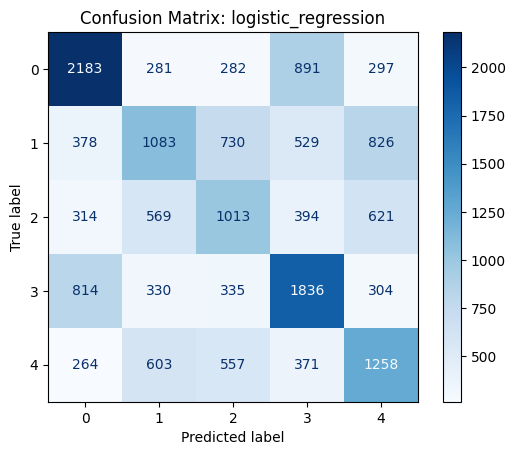

### 🥇 **logistic_regression** with 43.21% test accuracy!

,Model,Val Accuracy,Test Accuracy,Top-3 Accuracy,Macro-F1,Latency (ms)
0,logistic_regression,0.4344,0.4321,0.8363,0.4231,0.0


In [ ]:
df_results = evaluate_models(
    models,
    X_valid,
    y_valid,
    X_test,
    y_test,
    scaled_model_names=["logistic_regression", "svm", "simple_neural", "cnn"],
    show_confusion=True,
    k=3
)


### 10. Conclusion 😎